# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

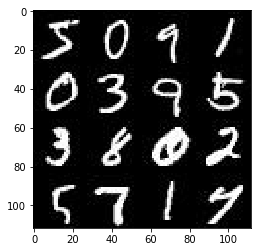

In [2]:
show_n_images = 20

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

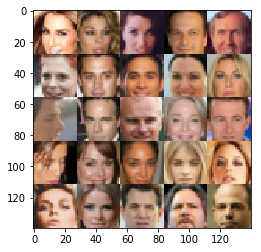

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [24]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # create 3 placeholder
    input_real = tf.placeholder(tf.float32,(None,image_width,image_height,image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32,(None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [45]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # create D
    with tf.variable_scope('discriminator',reuse=reuse):
        # input layer is 28*28*3
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same', 
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              bias_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False))
        relu1 = tf.maximum(0.2*x1,x1)
        # 14*14*64 now
        
        x2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same',
                                      kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              bias_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False))
        bn2 = tf.layers.batch_normalization(x2, training=True)        
        relu2 = tf.maximum(0.2*bn2,bn2)
        # 7*7*128 now
        
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same',
                                      kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              bias_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False))
        bn3 = tf.layers.batch_normalization(x3, training=True)        
        relu3 = tf.maximum(0.2*bn3,bn3)
        # 4*4*256 now      
        
        flat = tf.contrib.layers.flatten(relu3)
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [46]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # create G
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*128)
        x1 = tf.reshape(x1,(-1,7,7,128))
        x1 = tf.layers.batch_normalization(x1,training=is_train)
        x1 = tf.maximum(0.2*x1,x1)
        # 4*4*128 now
        
        x2 = tf.layers.conv2d_transpose(x1, 64, 4, strides=2, padding='same',
                                      kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False),
                              bias_initializer=tf.contrib.layers.xavier_initializer_conv2d(uniform=False))
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(0.2 * x2, x2)
        # 14 * 14 * 64 now
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 3, strides=2, padding='same')
        # 28 * 28 * out_channel_dim now
        
        out = tf.tanh(logits)
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [47]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # loss function
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    
    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [48]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # optimization
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #make batch_normalization work
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):  
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [49]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [50]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    input_real, input_z, lr = model_inputs(*data_shape[1:], z_dim)
    
    
    lr = learning_rate
    d_loss, g_loss = model_loss(input_real, input_z, len(data_image_mode))
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # random noise for G
                batch_z = np.random.uniform(-1,1, size=(batch_size, z_dim))
                
                #Run optimizer
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                # show_generator_output
                if steps % 10 == 0:
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, show_n_images, input_z, len(data_image_mode), data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6606... Generator Loss: 1.9038
Epoch 1/2... Discriminator Loss: 1.3149... Generator Loss: 0.5603
Epoch 1/2... Discriminator Loss: 0.8476... Generator Loss: 1.0954
Epoch 1/2... Discriminator Loss: 0.8905... Generator Loss: 1.0168
Epoch 1/2... Discriminator Loss: 1.0458... Generator Loss: 0.7881
Epoch 1/2... Discriminator Loss: 0.9178... Generator Loss: 1.1417
Epoch 1/2... Discriminator Loss: 1.9468... Generator Loss: 3.3924
Epoch 1/2... Discriminator Loss: 0.9320... Generator Loss: 1.5473
Epoch 1/2... Discriminator Loss: 0.8507... Generator Loss: 1.2386
Epoch 1/2... Discriminator Loss: 0.7628... Generator Loss: 1.9698


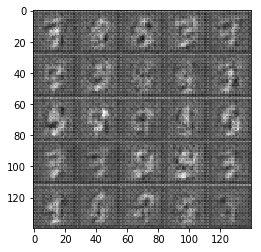

Epoch 1/2... Discriminator Loss: 0.9451... Generator Loss: 0.9398
Epoch 1/2... Discriminator Loss: 0.7420... Generator Loss: 1.2967
Epoch 1/2... Discriminator Loss: 0.7021... Generator Loss: 1.5026
Epoch 1/2... Discriminator Loss: 0.7026... Generator Loss: 1.2832
Epoch 1/2... Discriminator Loss: 1.3639... Generator Loss: 0.5449
Epoch 1/2... Discriminator Loss: 0.6496... Generator Loss: 2.0215
Epoch 1/2... Discriminator Loss: 0.6926... Generator Loss: 2.4940
Epoch 1/2... Discriminator Loss: 0.8172... Generator Loss: 3.1945
Epoch 1/2... Discriminator Loss: 0.5865... Generator Loss: 2.2467
Epoch 1/2... Discriminator Loss: 0.5728... Generator Loss: 2.6231


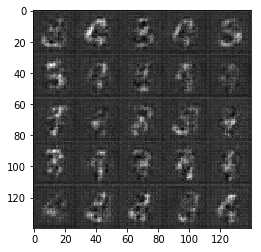

Epoch 1/2... Discriminator Loss: 0.5743... Generator Loss: 2.0199
Epoch 1/2... Discriminator Loss: 0.6264... Generator Loss: 3.5062
Epoch 1/2... Discriminator Loss: 0.6044... Generator Loss: 1.6851
Epoch 1/2... Discriminator Loss: 0.5120... Generator Loss: 2.1359
Epoch 1/2... Discriminator Loss: 0.4963... Generator Loss: 2.2811
Epoch 1/2... Discriminator Loss: 0.4901... Generator Loss: 2.3294
Epoch 1/2... Discriminator Loss: 0.5559... Generator Loss: 2.3295
Epoch 1/2... Discriminator Loss: 0.5780... Generator Loss: 1.6685
Epoch 1/2... Discriminator Loss: 0.7214... Generator Loss: 1.2851
Epoch 1/2... Discriminator Loss: 0.4644... Generator Loss: 2.6182


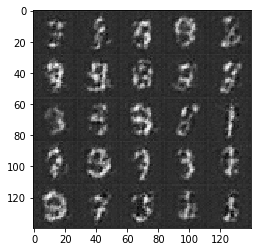

Epoch 1/2... Discriminator Loss: 0.4397... Generator Loss: 3.1106
Epoch 1/2... Discriminator Loss: 1.6878... Generator Loss: 0.3937
Epoch 1/2... Discriminator Loss: 0.6108... Generator Loss: 1.8364
Epoch 1/2... Discriminator Loss: 0.5479... Generator Loss: 1.8169
Epoch 1/2... Discriminator Loss: 0.4217... Generator Loss: 3.0636
Epoch 1/2... Discriminator Loss: 0.4718... Generator Loss: 3.3930
Epoch 1/2... Discriminator Loss: 0.4106... Generator Loss: 2.9608
Epoch 1/2... Discriminator Loss: 0.3895... Generator Loss: 3.2308
Epoch 1/2... Discriminator Loss: 0.5316... Generator Loss: 1.9595
Epoch 1/2... Discriminator Loss: 0.4427... Generator Loss: 2.4344


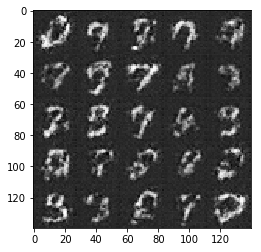

Epoch 1/2... Discriminator Loss: 1.3871... Generator Loss: 6.2781
Epoch 1/2... Discriminator Loss: 0.4927... Generator Loss: 3.3176
Epoch 1/2... Discriminator Loss: 0.4958... Generator Loss: 2.5429
Epoch 1/2... Discriminator Loss: 0.5090... Generator Loss: 1.9578
Epoch 1/2... Discriminator Loss: 0.4265... Generator Loss: 2.5932
Epoch 1/2... Discriminator Loss: 0.4025... Generator Loss: 3.5743
Epoch 1/2... Discriminator Loss: 0.4083... Generator Loss: 3.2833
Epoch 1/2... Discriminator Loss: 0.7273... Generator Loss: 2.2062
Epoch 1/2... Discriminator Loss: 0.4754... Generator Loss: 2.4755
Epoch 1/2... Discriminator Loss: 0.4574... Generator Loss: 2.3684


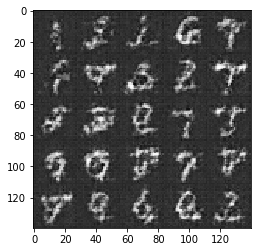

Epoch 1/2... Discriminator Loss: 0.5262... Generator Loss: 3.5929
Epoch 1/2... Discriminator Loss: 0.4492... Generator Loss: 2.3984
Epoch 1/2... Discriminator Loss: 0.4174... Generator Loss: 2.7899
Epoch 1/2... Discriminator Loss: 0.3997... Generator Loss: 2.9187
Epoch 1/2... Discriminator Loss: 0.4211... Generator Loss: 3.6551
Epoch 1/2... Discriminator Loss: 0.4318... Generator Loss: 3.1023
Epoch 1/2... Discriminator Loss: 0.5653... Generator Loss: 1.7769
Epoch 1/2... Discriminator Loss: 0.3845... Generator Loss: 3.3885
Epoch 1/2... Discriminator Loss: 0.3807... Generator Loss: 4.0355
Epoch 1/2... Discriminator Loss: 1.5799... Generator Loss: 5.7843


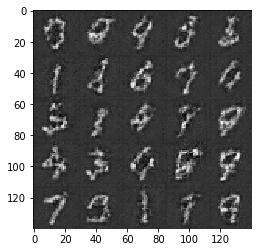

Epoch 1/2... Discriminator Loss: 0.5497... Generator Loss: 1.8259
Epoch 1/2... Discriminator Loss: 0.5078... Generator Loss: 2.5940
Epoch 1/2... Discriminator Loss: 0.4651... Generator Loss: 2.2846
Epoch 1/2... Discriminator Loss: 0.4766... Generator Loss: 4.0683
Epoch 1/2... Discriminator Loss: 0.4591... Generator Loss: 2.5738
Epoch 1/2... Discriminator Loss: 0.4439... Generator Loss: 2.5916
Epoch 1/2... Discriminator Loss: 0.4611... Generator Loss: 3.6036
Epoch 1/2... Discriminator Loss: 1.2916... Generator Loss: 0.6032
Epoch 1/2... Discriminator Loss: 0.4205... Generator Loss: 3.5933
Epoch 1/2... Discriminator Loss: 0.3606... Generator Loss: 4.6573


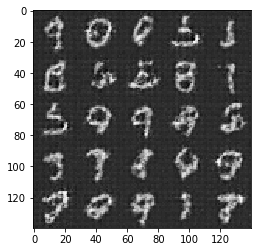

Epoch 1/2... Discriminator Loss: 0.3876... Generator Loss: 3.2643
Epoch 1/2... Discriminator Loss: 0.7014... Generator Loss: 1.3874
Epoch 1/2... Discriminator Loss: 0.4508... Generator Loss: 2.4258
Epoch 1/2... Discriminator Loss: 0.4395... Generator Loss: 2.4474
Epoch 1/2... Discriminator Loss: 0.4096... Generator Loss: 3.1682
Epoch 1/2... Discriminator Loss: 0.4834... Generator Loss: 2.2725
Epoch 1/2... Discriminator Loss: 0.5116... Generator Loss: 2.0551
Epoch 1/2... Discriminator Loss: 0.4901... Generator Loss: 2.2191
Epoch 1/2... Discriminator Loss: 3.6714... Generator Loss: 0.0582
Epoch 1/2... Discriminator Loss: 0.5958... Generator Loss: 1.6285


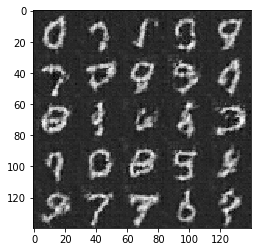

Epoch 1/2... Discriminator Loss: 0.4503... Generator Loss: 2.8729
Epoch 1/2... Discriminator Loss: 0.4739... Generator Loss: 2.4359
Epoch 1/2... Discriminator Loss: 0.4208... Generator Loss: 3.9443
Epoch 1/2... Discriminator Loss: 0.3861... Generator Loss: 4.5721
Epoch 1/2... Discriminator Loss: 0.6450... Generator Loss: 3.4686
Epoch 1/2... Discriminator Loss: 0.4707... Generator Loss: 3.0443
Epoch 1/2... Discriminator Loss: 0.4642... Generator Loss: 2.7262
Epoch 1/2... Discriminator Loss: 0.5735... Generator Loss: 1.6619
Epoch 1/2... Discriminator Loss: 0.4456... Generator Loss: 2.4243
Epoch 1/2... Discriminator Loss: 0.4039... Generator Loss: 2.9504


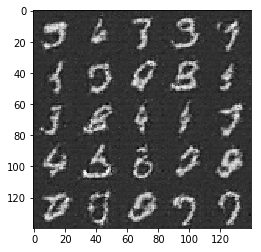

Epoch 1/2... Discriminator Loss: 0.4757... Generator Loss: 2.1615
Epoch 1/2... Discriminator Loss: 0.7485... Generator Loss: 1.9085
Epoch 1/2... Discriminator Loss: 0.7182... Generator Loss: 1.5120
Epoch 2/2... Discriminator Loss: 0.6782... Generator Loss: 1.4344
Epoch 2/2... Discriminator Loss: 0.5069... Generator Loss: 2.4226
Epoch 2/2... Discriminator Loss: 0.4582... Generator Loss: 2.3471
Epoch 2/2... Discriminator Loss: 0.4305... Generator Loss: 3.1619
Epoch 2/2... Discriminator Loss: 0.4214... Generator Loss: 2.7931
Epoch 2/2... Discriminator Loss: 0.4075... Generator Loss: 3.6726
Epoch 2/2... Discriminator Loss: 0.4841... Generator Loss: 2.9941


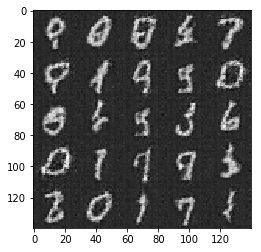

Epoch 2/2... Discriminator Loss: 0.3915... Generator Loss: 3.1572
Epoch 2/2... Discriminator Loss: 0.3771... Generator Loss: 3.4348
Epoch 2/2... Discriminator Loss: 0.4005... Generator Loss: 3.0481
Epoch 2/2... Discriminator Loss: 0.4348... Generator Loss: 3.0713
Epoch 2/2... Discriminator Loss: 0.4315... Generator Loss: 4.1742
Epoch 2/2... Discriminator Loss: 0.3750... Generator Loss: 3.4389
Epoch 2/2... Discriminator Loss: 0.4489... Generator Loss: 2.5956
Epoch 2/2... Discriminator Loss: 0.3783... Generator Loss: 4.3745
Epoch 2/2... Discriminator Loss: 0.3680... Generator Loss: 3.6489
Epoch 2/2... Discriminator Loss: 0.4274... Generator Loss: 5.5048


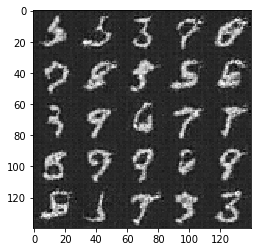

Epoch 2/2... Discriminator Loss: 0.6907... Generator Loss: 1.8925
Epoch 2/2... Discriminator Loss: 0.4770... Generator Loss: 3.0009
Epoch 2/2... Discriminator Loss: 0.4285... Generator Loss: 2.8411
Epoch 2/2... Discriminator Loss: 0.4638... Generator Loss: 3.4455
Epoch 2/2... Discriminator Loss: 0.4119... Generator Loss: 2.8095
Epoch 2/2... Discriminator Loss: 0.3786... Generator Loss: 3.4840
Epoch 2/2... Discriminator Loss: 0.7250... Generator Loss: 1.4729
Epoch 2/2... Discriminator Loss: 0.8215... Generator Loss: 1.1851
Epoch 2/2... Discriminator Loss: 0.4338... Generator Loss: 2.5758
Epoch 2/2... Discriminator Loss: 0.3990... Generator Loss: 3.0156


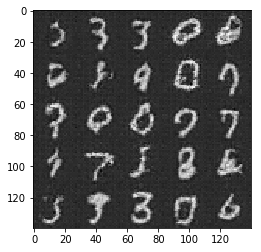

Epoch 2/2... Discriminator Loss: 0.4450... Generator Loss: 4.1868
Epoch 2/2... Discriminator Loss: 0.4210... Generator Loss: 3.8466
Epoch 2/2... Discriminator Loss: 0.4734... Generator Loss: 2.3926
Epoch 2/2... Discriminator Loss: 0.3973... Generator Loss: 3.2172
Epoch 2/2... Discriminator Loss: 0.3984... Generator Loss: 2.9846
Epoch 2/2... Discriminator Loss: 0.4551... Generator Loss: 2.4044
Epoch 2/2... Discriminator Loss: 0.4804... Generator Loss: 2.1875
Epoch 2/2... Discriminator Loss: 0.4896... Generator Loss: 2.2618
Epoch 2/2... Discriminator Loss: 0.3553... Generator Loss: 4.6229
Epoch 2/2... Discriminator Loss: 0.4239... Generator Loss: 3.2027


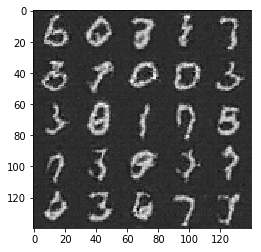

Epoch 2/2... Discriminator Loss: 0.4048... Generator Loss: 3.1863
Epoch 2/2... Discriminator Loss: 0.4623... Generator Loss: 5.0346
Epoch 2/2... Discriminator Loss: 0.9855... Generator Loss: 2.2019
Epoch 2/2... Discriminator Loss: 0.6287... Generator Loss: 2.0220
Epoch 2/2... Discriminator Loss: 1.5604... Generator Loss: 5.1342
Epoch 2/2... Discriminator Loss: 0.4671... Generator Loss: 2.4673
Epoch 2/2... Discriminator Loss: 0.7380... Generator Loss: 3.9276
Epoch 2/2... Discriminator Loss: 0.4979... Generator Loss: 2.7549
Epoch 2/2... Discriminator Loss: 0.4512... Generator Loss: 2.8482
Epoch 2/2... Discriminator Loss: 0.4840... Generator Loss: 2.2180


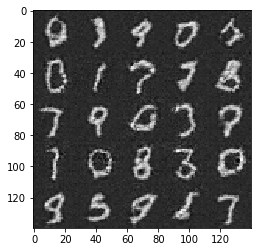

Epoch 2/2... Discriminator Loss: 0.4067... Generator Loss: 2.8439
Epoch 2/2... Discriminator Loss: 0.4193... Generator Loss: 3.1832
Epoch 2/2... Discriminator Loss: 0.4712... Generator Loss: 2.3717
Epoch 2/2... Discriminator Loss: 0.3977... Generator Loss: 3.0038
Epoch 2/2... Discriminator Loss: 0.4406... Generator Loss: 2.4935
Epoch 2/2... Discriminator Loss: 0.4993... Generator Loss: 2.1085
Epoch 2/2... Discriminator Loss: 1.3646... Generator Loss: 0.5924
Epoch 2/2... Discriminator Loss: 0.4895... Generator Loss: 2.2401
Epoch 2/2... Discriminator Loss: 0.4348... Generator Loss: 3.0571
Epoch 2/2... Discriminator Loss: 0.3931... Generator Loss: 3.1185


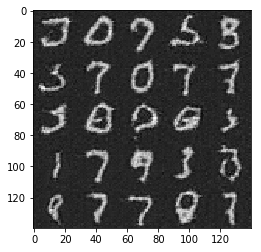

Epoch 2/2... Discriminator Loss: 0.4299... Generator Loss: 2.6878
Epoch 2/2... Discriminator Loss: 0.4531... Generator Loss: 3.3761
Epoch 2/2... Discriminator Loss: 0.3929... Generator Loss: 3.1518
Epoch 2/2... Discriminator Loss: 0.4045... Generator Loss: 5.0000
Epoch 2/2... Discriminator Loss: 0.4596... Generator Loss: 3.0444
Epoch 2/2... Discriminator Loss: 0.4376... Generator Loss: 2.8597
Epoch 2/2... Discriminator Loss: 0.3916... Generator Loss: 3.2748
Epoch 2/2... Discriminator Loss: 0.3784... Generator Loss: 3.5022
Epoch 2/2... Discriminator Loss: 0.3602... Generator Loss: 4.1062
Epoch 2/2... Discriminator Loss: 0.4091... Generator Loss: 4.4155


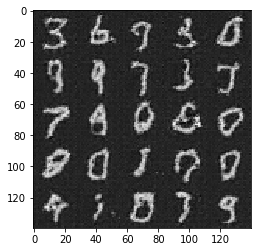

Epoch 2/2... Discriminator Loss: 0.3934... Generator Loss: 3.0340
Epoch 2/2... Discriminator Loss: 1.1149... Generator Loss: 2.8564
Epoch 2/2... Discriminator Loss: 0.7274... Generator Loss: 1.5797
Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 0.9638
Epoch 2/2... Discriminator Loss: 0.5303... Generator Loss: 2.5660
Epoch 2/2... Discriminator Loss: 0.4782... Generator Loss: 2.2603
Epoch 2/2... Discriminator Loss: 0.4485... Generator Loss: 3.1595
Epoch 2/2... Discriminator Loss: 0.4892... Generator Loss: 2.8396
Epoch 2/2... Discriminator Loss: 0.4319... Generator Loss: 3.3167
Epoch 2/2... Discriminator Loss: 0.4767... Generator Loss: 2.2198


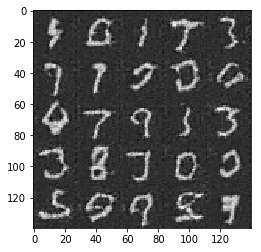

Epoch 2/2... Discriminator Loss: 0.4555... Generator Loss: 2.5174
Epoch 2/2... Discriminator Loss: 0.7153... Generator Loss: 1.4630
Epoch 2/2... Discriminator Loss: 0.4222... Generator Loss: 2.6585
Epoch 2/2... Discriminator Loss: 0.4269... Generator Loss: 2.7376
Epoch 2/2... Discriminator Loss: 0.4192... Generator Loss: 2.7167
Epoch 2/2... Discriminator Loss: 0.3979... Generator Loss: 3.0398
Epoch 2/2... Discriminator Loss: 0.3808... Generator Loss: 3.4960
Epoch 2/2... Discriminator Loss: 1.7572... Generator Loss: 0.4622
Epoch 2/2... Discriminator Loss: 0.4585... Generator Loss: 2.6088
Epoch 2/2... Discriminator Loss: 0.4216... Generator Loss: 2.8410


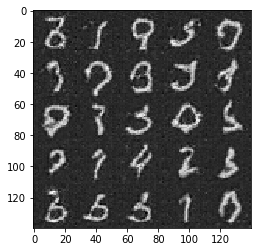

Epoch 2/2... Discriminator Loss: 0.4381... Generator Loss: 2.6736
Epoch 2/2... Discriminator Loss: 0.5121... Generator Loss: 2.2852
Epoch 2/2... Discriminator Loss: 0.3950... Generator Loss: 3.4866
Epoch 2/2... Discriminator Loss: 0.4153... Generator Loss: 2.7991
Epoch 2/2... Discriminator Loss: 0.3844... Generator Loss: 3.4873
Epoch 2/2... Discriminator Loss: 0.4187... Generator Loss: 2.7650
Epoch 2/2... Discriminator Loss: 0.3586... Generator Loss: 4.0092


In [51]:
batch_size = 64
z_dim = 10
learning_rate = .0005
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6190... Generator Loss: 1.6571
Epoch 1/1... Discriminator Loss: 0.5067... Generator Loss: 2.2696
Epoch 1/1... Discriminator Loss: 0.4410... Generator Loss: 2.7960
Epoch 1/1... Discriminator Loss: 0.4023... Generator Loss: 3.1660
Epoch 1/1... Discriminator Loss: 0.4503... Generator Loss: 2.5834
Epoch 1/1... Discriminator Loss: 0.4065... Generator Loss: 3.0133
Epoch 1/1... Discriminator Loss: 0.3606... Generator Loss: 3.8566
Epoch 1/1... Discriminator Loss: 0.3672... Generator Loss: 3.6662
Epoch 1/1... Discriminator Loss: 0.3811... Generator Loss: 4.2098
Epoch 1/1... Discriminator Loss: 0.6432... Generator Loss: 1.6208


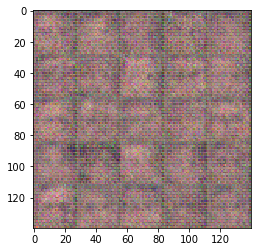

Epoch 1/1... Discriminator Loss: 0.5050... Generator Loss: 4.8818
Epoch 1/1... Discriminator Loss: 2.3805... Generator Loss: 0.1877
Epoch 1/1... Discriminator Loss: 0.5107... Generator Loss: 2.7683
Epoch 1/1... Discriminator Loss: 0.7077... Generator Loss: 1.2698
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 2.7359
Epoch 1/1... Discriminator Loss: 1.4750... Generator Loss: 0.4145
Epoch 1/1... Discriminator Loss: 0.8623... Generator Loss: 1.8848
Epoch 1/1... Discriminator Loss: 1.1052... Generator Loss: 0.6778
Epoch 1/1... Discriminator Loss: 1.0197... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 0.8235... Generator Loss: 1.6135


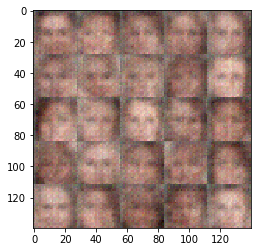

Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.5484
Epoch 1/1... Discriminator Loss: 0.8010... Generator Loss: 1.3690
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.4648
Epoch 1/1... Discriminator Loss: 0.7827... Generator Loss: 1.5025
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 2.0742
Epoch 1/1... Discriminator Loss: 0.9058... Generator Loss: 1.4355
Epoch 1/1... Discriminator Loss: 1.0192... Generator Loss: 1.5206
Epoch 1/1... Discriminator Loss: 1.2552... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 1.6032
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 1.5671


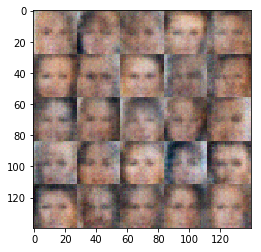

Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 0.8942
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 1.4775
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 2.0948
Epoch 1/1... Discriminator Loss: 1.0681... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 1.1773... Generator Loss: 1.2378
Epoch 1/1... Discriminator Loss: 0.9959... Generator Loss: 1.0405
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 1.0658
Epoch 1/1... Discriminator Loss: 1.2230... Generator Loss: 1.0018
Epoch 1/1... Discriminator Loss: 1.1356... Generator Loss: 0.9980
Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 1.1172


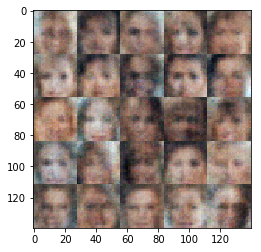

Epoch 1/1... Discriminator Loss: 1.4391... Generator Loss: 0.4615
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.5868
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.9968
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 0.9630
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 1.5629
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.2367... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 1.1292


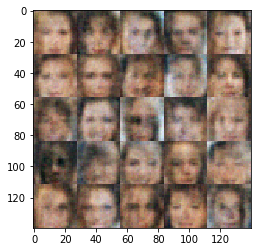

Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 0.8771
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 0.8867
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.1038... Generator Loss: 1.4133
Epoch 1/1... Discriminator Loss: 1.2684... Generator Loss: 1.5182
Epoch 1/1... Discriminator Loss: 1.0631... Generator Loss: 1.3518
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.6435
Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.2316... Generator Loss: 1.9243
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 1.4358


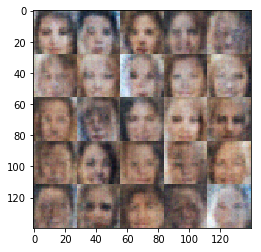

Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 0.9948
Epoch 1/1... Discriminator Loss: 0.9225... Generator Loss: 1.3303
Epoch 1/1... Discriminator Loss: 1.0199... Generator Loss: 0.9785
Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 1.4499
Epoch 1/1... Discriminator Loss: 1.0742... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 1.5515
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 1.2180
Epoch 1/1... Discriminator Loss: 0.9547... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 0.9993... Generator Loss: 1.2578
Epoch 1/1... Discriminator Loss: 1.1350... Generator Loss: 0.7513


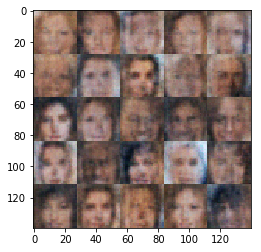

Epoch 1/1... Discriminator Loss: 0.8804... Generator Loss: 1.5218
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 1.4668
Epoch 1/1... Discriminator Loss: 1.0951... Generator Loss: 1.2098
Epoch 1/1... Discriminator Loss: 1.0850... Generator Loss: 1.2192
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 1.7781
Epoch 1/1... Discriminator Loss: 0.9696... Generator Loss: 1.0889
Epoch 1/1... Discriminator Loss: 1.0826... Generator Loss: 0.8356
Epoch 1/1... Discriminator Loss: 1.8009... Generator Loss: 1.8339
Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.2001
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 1.8139


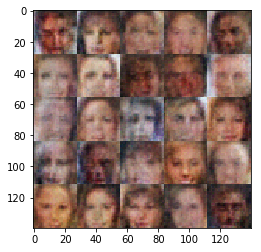

Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.5964
Epoch 1/1... Discriminator Loss: 1.0109... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 1.3489
Epoch 1/1... Discriminator Loss: 1.1294... Generator Loss: 0.9160
Epoch 1/1... Discriminator Loss: 1.1636... Generator Loss: 1.7221
Epoch 1/1... Discriminator Loss: 1.0447... Generator Loss: 1.1973
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 1.0628
Epoch 1/1... Discriminator Loss: 0.9506... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 1.3995
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.7485


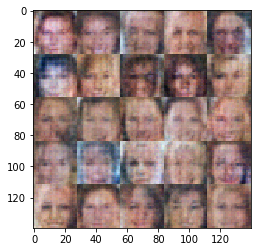

Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 1.0772
Epoch 1/1... Discriminator Loss: 1.1367... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.0753... Generator Loss: 1.1956
Epoch 1/1... Discriminator Loss: 1.0706... Generator Loss: 1.9395
Epoch 1/1... Discriminator Loss: 1.0800... Generator Loss: 0.8893
Epoch 1/1... Discriminator Loss: 1.1169... Generator Loss: 0.8178
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.8511
Epoch 1/1... Discriminator Loss: 1.5530... Generator Loss: 0.3801
Epoch 1/1... Discriminator Loss: 1.0167... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.7547


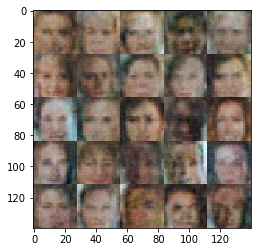

Epoch 1/1... Discriminator Loss: 0.9682... Generator Loss: 1.2747
Epoch 1/1... Discriminator Loss: 1.0186... Generator Loss: 1.3394
Epoch 1/1... Discriminator Loss: 1.0173... Generator Loss: 0.9543
Epoch 1/1... Discriminator Loss: 1.0458... Generator Loss: 1.4031
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.2735
Epoch 1/1... Discriminator Loss: 1.0102... Generator Loss: 1.1217
Epoch 1/1... Discriminator Loss: 1.1631... Generator Loss: 1.0001
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.5214
Epoch 1/1... Discriminator Loss: 1.2521... Generator Loss: 0.6499


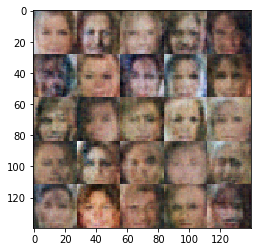

Epoch 1/1... Discriminator Loss: 1.0198... Generator Loss: 1.1089
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 1.0562
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 0.8530
Epoch 1/1... Discriminator Loss: 0.9950... Generator Loss: 1.1631
Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 0.9155
Epoch 1/1... Discriminator Loss: 1.2285... Generator Loss: 0.6473
Epoch 1/1... Discriminator Loss: 1.2378... Generator Loss: 0.7899
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.7568
Epoch 1/1... Discriminator Loss: 1.0750... Generator Loss: 1.4386


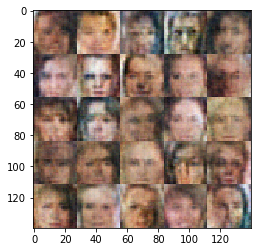

Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.0191... Generator Loss: 1.2994
Epoch 1/1... Discriminator Loss: 0.9985... Generator Loss: 1.0809
Epoch 1/1... Discriminator Loss: 1.2799... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 1.0985
Epoch 1/1... Discriminator Loss: 1.0055... Generator Loss: 1.1014
Epoch 1/1... Discriminator Loss: 0.9671... Generator Loss: 1.1358
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.9586
Epoch 1/1... Discriminator Loss: 1.1610... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3195... Generator Loss: 0.5757


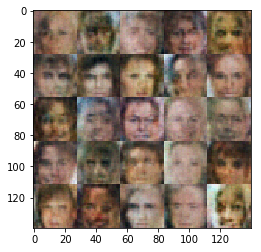

Epoch 1/1... Discriminator Loss: 1.0535... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.1081... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 0.9745... Generator Loss: 1.2995
Epoch 1/1... Discriminator Loss: 0.9679... Generator Loss: 1.2618
Epoch 1/1... Discriminator Loss: 0.8747... Generator Loss: 1.1232
Epoch 1/1... Discriminator Loss: 0.9192... Generator Loss: 1.2003
Epoch 1/1... Discriminator Loss: 1.1002... Generator Loss: 0.8409
Epoch 1/1... Discriminator Loss: 1.0215... Generator Loss: 0.8860
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 1.8740
Epoch 1/1... Discriminator Loss: 1.1464... Generator Loss: 0.7056


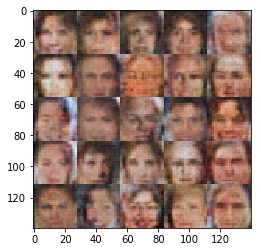

Epoch 1/1... Discriminator Loss: 1.1066... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.0757... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 0.8941
Epoch 1/1... Discriminator Loss: 0.9948... Generator Loss: 0.9780
Epoch 1/1... Discriminator Loss: 1.0398... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 0.9201... Generator Loss: 1.6192
Epoch 1/1... Discriminator Loss: 1.1994... Generator Loss: 1.4601
Epoch 1/1... Discriminator Loss: 1.5359... Generator Loss: 0.3991
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.1028... Generator Loss: 0.8203


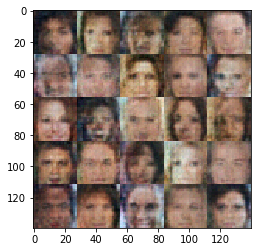

Epoch 1/1... Discriminator Loss: 0.9462... Generator Loss: 1.1339
Epoch 1/1... Discriminator Loss: 1.1422... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 0.8603... Generator Loss: 1.3607
Epoch 1/1... Discriminator Loss: 1.0525... Generator Loss: 0.9415
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 0.8646
Epoch 1/1... Discriminator Loss: 0.9572... Generator Loss: 1.2742
Epoch 1/1... Discriminator Loss: 0.9508... Generator Loss: 1.5200
Epoch 1/1... Discriminator Loss: 1.1497... Generator Loss: 0.8296


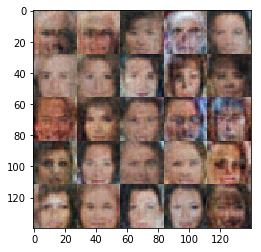

Epoch 1/1... Discriminator Loss: 0.8737... Generator Loss: 1.1738
Epoch 1/1... Discriminator Loss: 0.9610... Generator Loss: 1.1583
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 1.5931
Epoch 1/1... Discriminator Loss: 0.9980... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 0.9579... Generator Loss: 1.1044
Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 1.1015
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.0101
Epoch 1/1... Discriminator Loss: 1.2736... Generator Loss: 0.5616
Epoch 1/1... Discriminator Loss: 1.1224... Generator Loss: 1.1414
Epoch 1/1... Discriminator Loss: 1.1232... Generator Loss: 0.8288


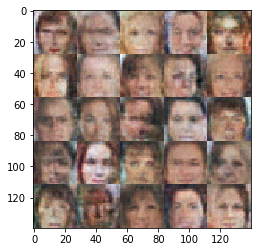

Epoch 1/1... Discriminator Loss: 0.9133... Generator Loss: 1.1683
Epoch 1/1... Discriminator Loss: 0.9463... Generator Loss: 1.4897
Epoch 1/1... Discriminator Loss: 0.9757... Generator Loss: 1.4962
Epoch 1/1... Discriminator Loss: 1.0045... Generator Loss: 0.9063
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 1.4917
Epoch 1/1... Discriminator Loss: 0.9832... Generator Loss: 1.5059
Epoch 1/1... Discriminator Loss: 1.0909... Generator Loss: 1.6959
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 1.0647
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 1.1923


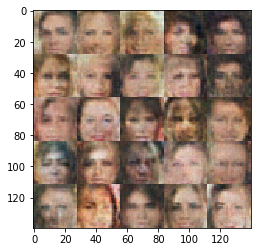

Epoch 1/1... Discriminator Loss: 1.0933... Generator Loss: 1.0260
Epoch 1/1... Discriminator Loss: 0.9235... Generator Loss: 1.0855
Epoch 1/1... Discriminator Loss: 0.7734... Generator Loss: 1.3854
Epoch 1/1... Discriminator Loss: 0.9577... Generator Loss: 1.0987
Epoch 1/1... Discriminator Loss: 1.2580... Generator Loss: 0.5990
Epoch 1/1... Discriminator Loss: 0.9466... Generator Loss: 1.2949
Epoch 1/1... Discriminator Loss: 0.9266... Generator Loss: 1.6228
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 0.9394... Generator Loss: 1.0433
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 0.9734


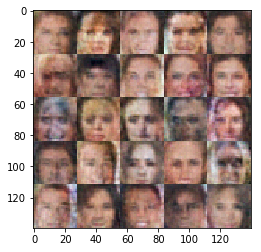

Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 0.9809... Generator Loss: 1.3928
Epoch 1/1... Discriminator Loss: 0.8970... Generator Loss: 1.3043
Epoch 1/1... Discriminator Loss: 1.0455... Generator Loss: 1.0677
Epoch 1/1... Discriminator Loss: 0.9094... Generator Loss: 1.2974
Epoch 1/1... Discriminator Loss: 0.9111... Generator Loss: 1.2807
Epoch 1/1... Discriminator Loss: 0.9975... Generator Loss: 0.9219
Epoch 1/1... Discriminator Loss: 0.9315... Generator Loss: 1.2539
Epoch 1/1... Discriminator Loss: 0.9977... Generator Loss: 1.3754
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.7000


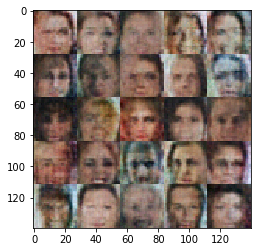

Epoch 1/1... Discriminator Loss: 0.9350... Generator Loss: 0.9599
Epoch 1/1... Discriminator Loss: 0.8910... Generator Loss: 1.1918
Epoch 1/1... Discriminator Loss: 1.0487... Generator Loss: 1.5033
Epoch 1/1... Discriminator Loss: 0.9926... Generator Loss: 1.3501
Epoch 1/1... Discriminator Loss: 0.8571... Generator Loss: 1.5190
Epoch 1/1... Discriminator Loss: 0.9184... Generator Loss: 1.0427
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.6112
Epoch 1/1... Discriminator Loss: 1.1845... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 0.9219... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 2.0539


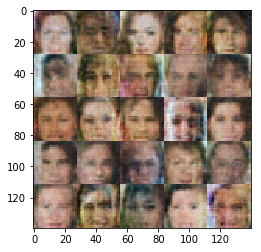

Epoch 1/1... Discriminator Loss: 1.2813... Generator Loss: 0.5626
Epoch 1/1... Discriminator Loss: 0.9726... Generator Loss: 1.2434
Epoch 1/1... Discriminator Loss: 0.9536... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 0.9418... Generator Loss: 1.6829
Epoch 1/1... Discriminator Loss: 1.0907... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.0610... Generator Loss: 1.1296
Epoch 1/1... Discriminator Loss: 0.8548... Generator Loss: 1.2980
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 0.9258
Epoch 1/1... Discriminator Loss: 1.0552... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.0495... Generator Loss: 0.8035


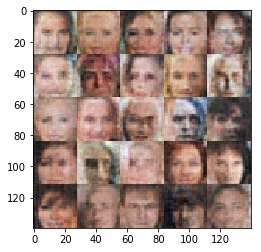

Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 1.2766
Epoch 1/1... Discriminator Loss: 1.0390... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 1.2457
Epoch 1/1... Discriminator Loss: 1.0084... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.0330... Generator Loss: 1.0382
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.2986
Epoch 1/1... Discriminator Loss: 0.9289... Generator Loss: 0.8875
Epoch 1/1... Discriminator Loss: 1.0913... Generator Loss: 1.3434
Epoch 1/1... Discriminator Loss: 0.7032... Generator Loss: 1.3820
Epoch 1/1... Discriminator Loss: 0.6913... Generator Loss: 1.8298


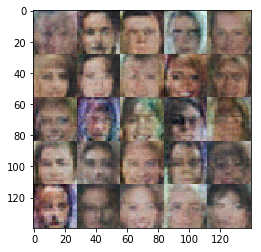

Epoch 1/1... Discriminator Loss: 1.0041... Generator Loss: 1.0331
Epoch 1/1... Discriminator Loss: 0.9420... Generator Loss: 0.9534
Epoch 1/1... Discriminator Loss: 0.8864... Generator Loss: 1.1718
Epoch 1/1... Discriminator Loss: 0.8480... Generator Loss: 1.1168
Epoch 1/1... Discriminator Loss: 0.9532... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 0.8337... Generator Loss: 1.2191
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 1.5878
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.1012
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 0.7327
Epoch 1/1... Discriminator Loss: 0.7896... Generator Loss: 1.1048


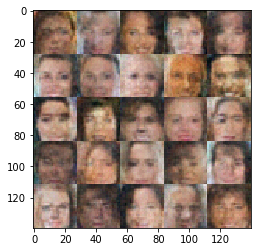

Epoch 1/1... Discriminator Loss: 0.9349... Generator Loss: 1.3548
Epoch 1/1... Discriminator Loss: 0.9905... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 0.7032... Generator Loss: 1.4106
Epoch 1/1... Discriminator Loss: 0.6146... Generator Loss: 1.6038
Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.4272
Epoch 1/1... Discriminator Loss: 1.1669... Generator Loss: 0.6815
Epoch 1/1... Discriminator Loss: 0.8905... Generator Loss: 0.9522
Epoch 1/1... Discriminator Loss: 0.9607... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.1112... Generator Loss: 1.9627
Epoch 1/1... Discriminator Loss: 0.8741... Generator Loss: 1.1875


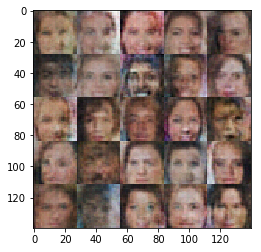

Epoch 1/1... Discriminator Loss: 0.6791... Generator Loss: 1.6665
Epoch 1/1... Discriminator Loss: 1.0468... Generator Loss: 0.8075
Epoch 1/1... Discriminator Loss: 0.7898... Generator Loss: 1.2745
Epoch 1/1... Discriminator Loss: 0.9819... Generator Loss: 0.9444
Epoch 1/1... Discriminator Loss: 0.8040... Generator Loss: 1.1778
Epoch 1/1... Discriminator Loss: 0.9136... Generator Loss: 1.0012
Epoch 1/1... Discriminator Loss: 0.9039... Generator Loss: 1.6027
Epoch 1/1... Discriminator Loss: 0.8311... Generator Loss: 1.2488
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.1013
Epoch 1/1... Discriminator Loss: 1.1820... Generator Loss: 0.6851


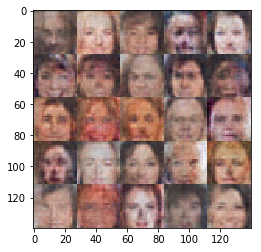

Epoch 1/1... Discriminator Loss: 0.8565... Generator Loss: 1.0967
Epoch 1/1... Discriminator Loss: 1.0427... Generator Loss: 1.0364
Epoch 1/1... Discriminator Loss: 0.8958... Generator Loss: 1.0901
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 1.6625
Epoch 1/1... Discriminator Loss: 0.8946... Generator Loss: 1.0698
Epoch 1/1... Discriminator Loss: 0.7051... Generator Loss: 2.5524
Epoch 1/1... Discriminator Loss: 0.8505... Generator Loss: 1.1960
Epoch 1/1... Discriminator Loss: 1.0081... Generator Loss: 1.0516
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 0.9619... Generator Loss: 1.0805


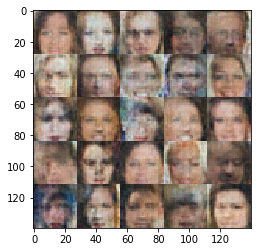

Epoch 1/1... Discriminator Loss: 0.7895... Generator Loss: 1.2697
Epoch 1/1... Discriminator Loss: 1.1187... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.5041... Generator Loss: 0.4086
Epoch 1/1... Discriminator Loss: 0.9283... Generator Loss: 1.0013


In [52]:
batch_size = 64
z_dim = 32
learning_rate = .0002
beta1 = .5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.